## Graph Convolutional Neural Network

In [ ]:
from spacebench.algorithms.gcn import GCNModel
import matplotlib.pyplot as plt

In [2]:
from spacebench import (
    SpaceEnv,
    SpaceDataset,
    DataMaster,
    DatasetEvaluator,
    EnvEvaluator,
)

In [3]:
envname = "healthd_dmgrcs_mortality_disc"
env = SpaceEnv(envname, dir="downloads")
env.__dict__.keys()
dataset = env.make()

In [ ]:
model = GCNModel(
    dataset,
    True,
    weight_decay=0.005, 
    lr=0.001
)

## Predictions

In [ ]:
erf, counterfactuals = model.gcn()

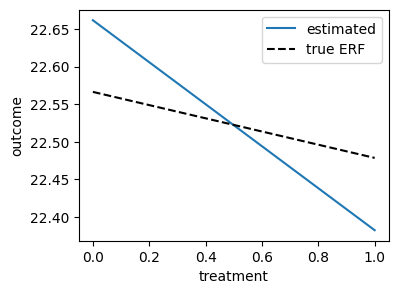

In [6]:
# plot comparing estimated and true erf
erf_true = dataset.erf()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(dataset.treatment_values, counterfactuals.mean(0), label="estimated")
ax.plot(dataset.treatment_values, erf_true, label="true ERF", linestyle="--", color="k")
ax.set_xlabel("treatment")
ax.set_ylabel("outcome")
ax.legend()